# Linear NMM Example

Created by: Andrew Clappison et al. (i.e., Taha Morshedzadeh, Sorenza Bastiaens, Parsa Oveisi, Zheng Wang, Kevin Kadak)

Version: August 2022

In [2]:
import torch
import seaborn as sns

from whobpyt.models import LinearRNN_Params,LinearRNN_Layer,RNNJANSEN,ParamsJR,RNNWWD,RWW_Layer,RWW_Params,BOLD_Layer,BOLD_Params,EEG_Layer,EEG_Params,Jansen_Layer

from whobpyt.objective import meanVariableLoss,powerSpectrumLoss,functionalConnectivityLoss

from whobpyt.fit import Model_fitting

In [3]:
# This is the matrix you would like the correlation matrix of RNN output to be, 
# representing a BOLD Functional Connectivity Matrix.
# When calculating the correlation error we only use the upper or lower triangle (Functional Connectivity is symmetric)

# The generation of this synthetic FC is not important.
# You can replace this syntetic FC with an empirical FC matrix if you like!
num_regions = 40
temp = (2*torch.rand(num_regions,num_regions)-1)
temp[range(num_regions), range(num_regions)] = 1
temp[range(0,20),range(20,40)] = 1
temp[range(20,40), range(0,20)] = 1
targetFC = (temp + torch.transpose(temp, 0,1))/2

# This is to get the upper triangle of the FC Matrix.
triIdx = torch.triu_indices(40, 40, 1)
targetFCvec = targetFC[triIdx[0], triIdx[1]]

<AxesSubplot:>

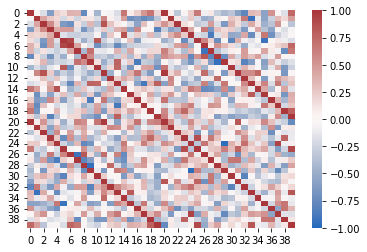

In [4]:
# Visualization of the Target FC
sns.heatmap(targetFC, vmin = -1, vmax = 1, cmap = "vlag") # Visualization of FC to be fitted to

In [5]:
# THREE HYPERPARAMETERS TO ADJUST
learning_rate = 0.001
num_epochs = 100
input_length = 1000


init_state = torch.rand(40)
sim_len = input_length
step_size = 1
use_noise = True

# Create the RNN object and give it's parameters to the optimizer
params = LinearRNN_Params(num_regions=40)
params.SC = torch.nn.parameter.Parameter(params.SC)
# rnn = LinearRNN_Layer(init_state, sim_len, step_size, use_noise)
rnn = LinearRNN_Layer(num_regions=num_regions, params=params, step_size=step_size)
optimizer = torch.optim.Adam(rnn.parameters(), lr = learning_rate) 

# This is where we do the model training
for i in range(num_epochs):
    
    #noise = torch.randn(input_length, 1, num_regions) # Create input noise to RNN
    output, hn = rnn(init_state, sim_len) # Run the RNN
    simFC = torch.corrcoef(torch.transpose(torch.squeeze(output, 1), 0, 1))  # Calculate the Functional Connectivity of the RNN output
    simFCvec = simFC[triIdx[0], triIdx[1]] #Extract upper traingle of RNN Functional Connectivity
    corVal = torch.corrcoef(torch.stack((targetFCvec, simFCvec)))[0,1] # Correlated RNN FC (upper triangle) with Target FC (upper triangle)

    # Choose one of the below loss functions (NOTE: Only 1 should be uncommented)
    loss = -torch.log(0.5 + 0.5*corVal) # Calculate the FC loss
    #loss = torch.nn.functional.mse_loss(simFC, targetFC) # Calculate the MSE Loss
    #loss = -torch.log(0.5 + 0.5*corVal) + torch.nn.functional.mse_loss(simFC, targetFC) #Combined Loss Option
    
    print("Epoch:", i, " has FC Correlation:", corVal.item())
    
    loss.backward() # Backpropagate through network to determine gradients 
    optimizer.step() # Update RNN Parameters based on the gradients
    optimizer.zero_grad() # Reset the gradients to zero
    


Epoch: 0  has FC Correlation: 0.018322071060538292
Epoch: 1  has FC Correlation: 0.007155312690883875
Epoch: 2  has FC Correlation: 0.01594868116080761
Epoch: 3  has FC Correlation: 0.07752445340156555
Epoch: 4  has FC Correlation: 0.13171176612377167
Epoch: 5  has FC Correlation: 0.11323843896389008
Epoch: 6  has FC Correlation: 0.06778447329998016
Epoch: 7  has FC Correlation: 0.15829521417617798
Epoch: 8  has FC Correlation: 0.1433115005493164
Epoch: 9  has FC Correlation: 0.1431175321340561
Epoch: 10  has FC Correlation: 0.19783812761306763
Epoch: 11  has FC Correlation: 0.23899134993553162
Epoch: 12  has FC Correlation: 0.2666313052177429
Epoch: 13  has FC Correlation: 0.314689576625824
Epoch: 14  has FC Correlation: 0.39498448371887207
Epoch: 15  has FC Correlation: 0.3545588552951813
Epoch: 16  has FC Correlation: 0.3549775183200836
Epoch: 17  has FC Correlation: 0.4555738866329193
Epoch: 18  has FC Correlation: 0.45130783319473267
Epoch: 19  has FC Correlation: 0.47438788414001

<AxesSubplot:>

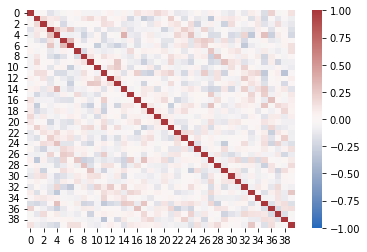

In [7]:
# Plotting the FC of the RNN Output
sns.heatmap(simFC.detach().numpy(), vmin = -1, vmax = 1, cmap = "vlag")

<AxesSubplot:>

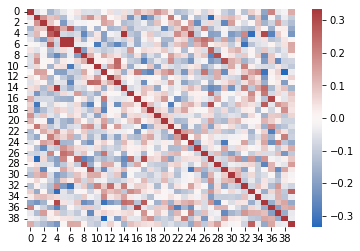

In [9]:
# Plotting the FC of the RNN Output - with different scale
zoom = 3 #Adjust Zoom
sns.heatmap(simFC.detach().numpy(), vmin = -1/zoom, vmax = 1/zoom, cmap = "vlag")